## Name: Saikat Bera
## Email: saikatb@cmi.ac.in
## Roll No.: MDS202228

# Part 1

In [1]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v2
from torchvision.transforms import Normalize, Resize, Compose, RandomRotation, RandomHorizontalFlip, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [9]:
# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set up parameters
batch_size = 20
train_samples = 100
val_samples = 20
test_samples = 20
img_size = 256  # updated to match your image size

# Set paths to datasets
base_dir = '/content/drive/MyDrive/data'
chicken_train_dir = f'{base_dir}/chicken-images/data/train'
chicken_val_dir = f'{base_dir}/chicken-images/data/val'
chicken_test_dir = f'{base_dir}/chicken-images/data/test'
duck_train_dir = f'{base_dir}/duck-images/data/train'
duck_val_dir = f'{base_dir}/duck-images/data/val'
duck_test_dir = f'{base_dir}/duck-images/data/test'

# Define image transforms
transform = Compose([
    Resize((img_size, img_size)),
    RandomRotation(40),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create custom dataset class
class ChickenDuckDataset(Dataset):
    def __init__(self, chicken_dir, duck_dir, transform=None):
        self.chicken_dir = chicken_dir
        self.duck_dir = duck_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        # Load chicken images
        chicken_files = os.listdir(self.chicken_dir)[:train_samples]
        for img_path in chicken_files:
            self.images.append(os.path.join(self.chicken_dir, img_path))
            self.labels.append(0)  # 0 for chicken

        # Load duck images
        duck_files = os.listdir(self.duck_dir)[:train_samples]
        for img_path in duck_files:
            self.images.append(os.path.join(self.duck_dir, img_path))
            self.labels.append(1)  # 1 for duck

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

Using device: cuda:0


In [10]:
# Create train, validation, and test datasets
train_dataset = ChickenDuckDataset(chicken_train_dir, duck_train_dir, transform=transform)
val_dataset = ChickenDuckDataset(chicken_val_dir, duck_val_dir, transform=transform)
test_dataset = ChickenDuckDataset(chicken_test_dir, duck_test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load MobileNetV2 pre-trained model
model = mobilenet_v2(pretrained=True)

# Freeze the base model
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer
num_classes = 1
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.0001)

In [11]:
# Train the model
num_epochs = 50
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Accuracy calculation
        predicted = torch.round(torch.sigmoid(outputs))
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

            # Accuracy calculation
            predicted = torch.round(torch.sigmoid(outputs))
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracy_history.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/50], Train Loss: 0.6603, Train Accuracy: 0.6000, Val Loss: 0.6555, Val Accuracy: 0.6842
Epoch [2/50], Train Loss: 0.6267, Train Accuracy: 0.6700, Val Loss: 0.6368, Val Accuracy: 0.7368
Epoch [3/50], Train Loss: 0.6374, Train Accuracy: 0.6750, Val Loss: 0.6461, Val Accuracy: 0.6711
Epoch [4/50], Train Loss: 0.6096, Train Accuracy: 0.7250, Val Loss: 0.6300, Val Accuracy: 0.7434
Epoch [5/50], Train Loss: 0.5932, Train Accuracy: 0.7800, Val Loss: 0.6171, Val Accuracy: 0.7961
Epoch [6/50], Train Loss: 0.5749, Train Accuracy: 0.8200, Val Loss: 0.6047, Val Accuracy: 0.7632
Epoch [7/50], Train Loss: 0.5684, Train Accuracy: 0.8100, Val Loss: 0.5954, Val Accuracy: 0.7895
Epoch [8/50], Train Loss: 0.5639, Train Accuracy: 0.8050, Val Loss: 0.5805, Val Accuracy: 0.8421
Epoch [9/50], Train Loss: 0.5497, Train Accuracy: 0.8300, Val Loss: 0.5705, Val Accuracy: 0.8355
Epoch [10/50], Train Loss: 0.5307, Train Accuracy: 0.8700, Val Loss: 0.5671, Val Accuracy: 0.8421
Epoch [11/50], Train Loss: 0.

In [12]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_preds = []
test_true = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        test_loss += loss.item()
        test_preds.extend(torch.sigmoid(outputs).squeeze().cpu().numpy().tolist())
        test_true.extend(labels.cpu().numpy().tolist())
test_loss /= len(test_loader)

test_preds = [1 if p > 0.5 else 0 for p in test_preds]
print(classification_report(test_true, test_preds, target_names=['Chicken', 'Duck']))

              precision    recall  f1-score   support

     Chicken       0.93      0.89      0.91       100
        Duck       0.89      0.93      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



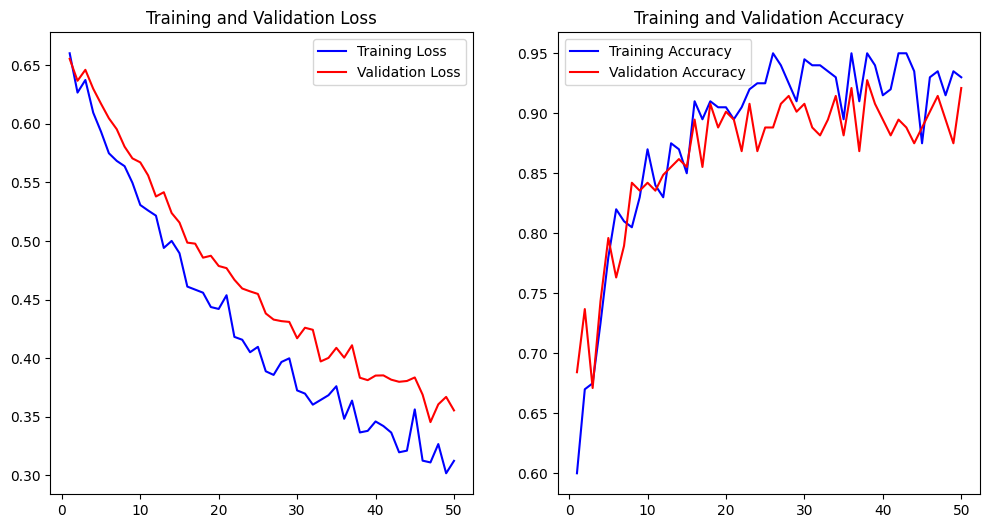

In [13]:
# Plot the training and validation curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, 'b', label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss_history, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy_history, 'b', label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy_history, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()